# Choose whether to ignore warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Load data

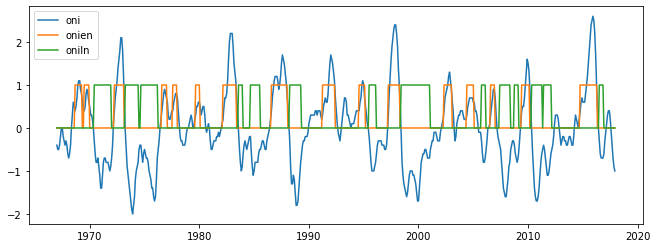

In [2]:
%run wcpfc_load_and_calc.ipynb

# Extra things to load

In [4]:
from calc_po2 import calc_po2
#import sys; del sys.modules['calc_po2']
import gsw
import scipy as sp

# Load WOD18 data

In [5]:
# Load o2, temp, sal from WOD18 nc files (already on good grid)
# -->Get SST, O2100, SSS
# -->Compute THD, TCD, O2100INT, T100INT

In [6]:
ncfile = dpath + 'WOD18/o2_195501-201807_5deg.nc'
o2 = xr.open_dataset(ncfile) # umol/kg
o2 = o2['O2']; o2.name = 'o2'
ncfile = dpath + 'WOD18/sal_195501-201807_5deg.nc'
sal = xr.open_dataset(ncfile) # psu
sal = sal['Sal']; sal.name = 'sal'
ncfile = dpath + 'WOD18/temp_195501-201807_5deg.nc'
temp = xr.open_dataset(ncfile) # degC
temp = temp['Temp']; temp.name = 'temp'

### Correct the time axis

In [7]:
# - Time goes from Jan 1955 - Jul 2018 --> 763 months
begdatewod = datetime.date(year = 1955, month = 1, day = 1)
enddatewod = datetime.date(year = 2018, month = 7, day = 1)
timemowod = pd.date_range(begdatewod, enddatewod, freq='MS')

In [8]:
o2['time'] = timemowod
sal['time'] = timemowod
temp['time'] = timemowod

### Change from -180-180 to 0-360 lon

In [9]:
# https://github.com/pydata/xarray/issues/577 - wrap 0 to 360
# https://github.com/pydata/xarray/issues/1875 - roll
temp['lon'] = np.mod(temp['lon'], 360)
temp = temp.reindex({'lon': np.sort(temp['lon'])}) # or: temp = temp.roll(lon=36)
o2['lon'] = np.mod(o2['lon'], 360)
o2 = o2.reindex({'lon': np.sort(o2['lon'])}) # or: o2 = o2.roll(lon=36)
sal['lon'] = np.mod(sal['lon'], 360)
sal = sal.reindex({'lon': np.sort(sal['lon'])}) # or: sal = sal.roll(lon=36)

### Calculate derived variables

sst, o2100, sss

In [10]:
sst = temp.isel(depth=0); sst.name = 'sst'
o2100 = o2.sel(depth=100); o2100.name = 'o2100'
sss = sal.isel(depth=0); sss.name = 'sss'

absolute salinity

In [11]:
# Calculate absolute salinity
# https://teos-10.github.io/GSW-Python/conversions.html
loadabsal = 1
if loadabsal==0:
    absal = sal * np.nan
    for ilat in range(sal.lat.size):
        for ilon in range(sal.lon.size):
            absal[:,:,ilat,ilon] = gsw.conversions.SA_from_SP(sal[:,:,ilat,ilon], sal.depth, sal.lon[ilon], sal.lat[ilat])
    absal.name = 'absal'
    absal.to_netcdf(dpath + 'WOD18/absal_195501-201807_5deg.nc')
elif loadabsal==1:
    ncfile = dpath + 'WOD18/absal_195501-201807_5deg.nc'
    absal = xr.open_dataset(ncfile) # g/kg
    absal = absal['absal']
# Test:
#absal.mean(dim='time').sel(depth=5).plot()
#sal.mean(dim='time').sel(depth=5).plot()

potential temperature

In [12]:
# Calculate potential temperature
# https://teos-10.github.io/GSW-Python/conversions.html
loadpottemp = 1
if loadpottemp==0:
    pottemp = temp * np.nan
    for ilat in range(temp.lat.size):
        for ilon in range(temp.lon.size):
            pottemp[:,:,ilat,ilon] = gsw.conversions.pt0_from_t(absal[:,:,ilat,ilon], temp[:,:,ilat,ilon], temp.depth)
    pottemp.name = 'pottemp'
    pottemp.to_netcdf(dpath + 'WOD18/pottemp_195501-201807_5deg.nc')
elif loadpottemp==1:
    ncfile = dpath + 'WOD18/pottemp_195501-201807_5deg.nc'
    pottemp = xr.open_dataset(ncfile) # degC
    pottemp = pottemp['pottemp']
# Test:
#(pottemp.mean(dim='time').sel(depth=5000)-temp.mean(dim='time').sel(depth=5000)).plot() # should be all negative

po2

In [13]:
# Compute po2
loadpo2 = 1
if loadpo2==0:
    po2 = calc_po2(o2,temp,sal,o2.depth)
    po2.name = 'po2'
    po2.to_netcdf(dpath + 'WOD18/po2_195501-201807_5deg.nc')
elif loadpo2==1:
    ncfile = dpath + 'WOD18/po2_195501-201807_5deg.nc' 
    po2 = xr.open_dataset(ncfile) # kPa
    po2 = po2['po2']
# Test:
#po2.mean(dim='time').sel(depth=100).plot()
#o2.mean(dim='time').sel(depth=100).plot()

tuna hypoxic depth (thd)

In [167]:
# Compute THD
loadthd = 1
if loadthd==0:
    thd = xr.full_like(o2100,np.nan)
    thd.name = 'thd'; thd.attrs['units'] = 'm';
    thd.attrs['long_name'] = 'tuna hypoxic depth (15kPa)'
    for ilon in range(thd.lon.size):
        print(ilon)
        for ilat in range(thd.lat.size):
            for itime in range(thd.time.size):
                po2profnow = po2.isel(lat=ilat,lon=ilon,time=itime)
                po2profnow = po2profnow[~np.isnan(po2profnow)]
                if len(po2profnow)>0: # get rid of case in which po2profnow is all nans
                    if (po2profnow.min()<=thp) & (po2profnow.max()>=thp):
                        didxdeep = np.argmax(po2profnow<=thp).values
                        if didxdeep>0:
                        # get rid of case in which you have a strangely tiny po2 pressure < thp
                        # at the very top of the profile (i.e., either start measuring in mid depth of
                        # OMZ or you have erroneously small po2 pressure at/near the surface)
                            interpf = sp.interpolate.interp1d(
                                po2profnow.isel(depth=slice(didxdeep-1,didxdeep+1)),
                                po2profnow['depth'].isel(depth=slice(didxdeep-1,didxdeep+1)))
                            thd[itime,ilat,ilon] = interpf(thp)
    thd.to_netcdf(dpath + 'WOD18/thd_195501-201807_5deg.nc')
elif loadthd==1:
    ncfile = dpath + 'WOD18/thd_195501-201807_5deg.nc' 
    thd = xr.open_dataset(ncfile) # m
    thd = thd['thd']
# Test:
#po2.mean(dim='time').sel(depth=100).plot()
#o2.mean(dim='time').sel(depth=100).plot()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


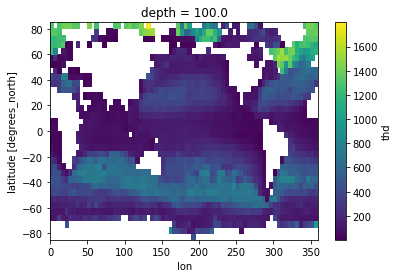

In [168]:
thd.mean(dim='time').plot()

In [ ]:
# Loop over looking at every single po2 profile within chosen range
# %matplotlib inline
# 
# from IPython.display import clear_output
# 
# thp = 15 # kPa
# lonnow = thd.lon.sel(lon=slice(100,270))
# latnow = thd.lat.sel(lat=slice(-15,15))
# po2now = po2.sel(lon=slice(100,270),lat=slice(-15,15))
# 
# #for ilon in range(thd.lon.size):
# for ilon in range(lonnow.size):
#     #for ilat in range(thd.lat.size):
#     for ilat in range(latnow.size):
#         for itime in range(thd.time.size):
#             po2profnow = po2now.isel(lat=ilat,lon=ilon,time=itime)
#             if (po2profnow.min()<thp) & (po2profnow.max()>thp):
#             #if (po2profnow.min()>thp):
#             #if (po2profnow.max()<thp):
#                 clear_output(wait=True)
#                 po2profnow.plot(y='depth',yincrease=False)
#                 plt.title('lon=' + str(lonnow[ilon].values) + ',lat=' + str(latnow[ilat].values) + ',time=' + str(thd.time[itime].values)[:10])
#                 plt.ylim(500,0)
#                 plt.pause(1)

thermocline depth (TCD)

In [ ]:
# Calculate thermocline temperature 3D (x,y,time) map for variable isotherm method
tmld = temp-0.8
ttc = tmld-0.25*(tmld-temp.sel(depth=400))

In [ ]:
# Compute TCD
loadtcd = 0; tcdtype = 'variable'; # choose 'variable','20degC'
if loadtcd==0:
    tcd = xr.full_like(sst,np.nan)
    tcd.name = 'tcd'; tcd.attrs['units'] = 'm';
    tcd.attrs['long_name'] = 'thermocline depth (' + tcdtype + 'isotherm method)'
    if tcdtype=='20degC':
        ttcnow = 20;
    for ilon in range(tcd.lon.size):
        for ilat in range(tcd.lat.size):
            for itime in range(tcd.time.size):
                tempprofnow = temp.isel(lat=ilat,lon=ilon,time=itime)
                tempprofnow = tempprofnow[~np.isnan(tempprofnow)]
                if len(tempprofnow)>0: # get rid of case in which tempprofnow is all nans
                    if tcdtype=='variable':
                        ttcnow = ttc.isel(lat=ilat,lon=ilon,time=itime).values
                    if (tempprofnow.min()<=ttcnow) & (tempprofnow.max()>=ttcnow):
                        didxdeep = np.argmax(tempprofnow<=ttcnow).values
                        if didxdeep>0:
                        # get rid of case in which you have a strangely tiny temp pressure < ttcnow
                        # at the very top of the profile (i.e., either start measuring in mid depth of
                        # OMZ or you have erroneously small temp pressure at/near the surface)
                            interpf = sp.interpolate.interp1d(
                                tempprofnow.isel(depth=slice(didxdeep-1,didxdeep+1)),
                                tempprofnow['depth'].isel(depth=slice(didxdeep-1,didxdeep+1)))
                            tcd[itime,ilat,ilon] = interpf(ttcnow)
    tcd.to_netcdf(dpath + 'WOD18/tcd_195501-201807_5deg.nc')
elif loadtcd==1:
    ncfile = dpath + 'WOD18/tcd_195501-201807_5deg.nc' 
    tcd = xr.open_dataset(ncfile) # m
    tcd = tcd['tcd']

po2100int, temp100int

In [ ]:
# Compute O2100INT, T100INT
# http://xarray.pydata.org/en/stable/generated/xarray.DataArray.integrate.html
po2100int = xr.full_like(o2100,np.nan) 
po2100int.name = 'po2100int'; po2100int.attrs['units'] = 'm kPa'
po2100int.attrs['long_name'] = 'po2 integrated down to 100-m depth'

# get only profiles where deepest measurement is >100 m and shallowest measurement is <10 m
# get only profiles where there are >1 measurements between 10 and 100 m 
po2.sel(depth=slice(0,100)).integrate('depth')

po210to100 = po2.sel(depth=slice(10,100))
po210to100count = po210to100.count(dim='depth',skipna=True)

po2['depth']
deepestnonnandepth = po2['depth'][~np.isnan(po2).argmax(dim='depth')]
tempprofnow[~np.isnan(tempprofnow)]
didxdeep = np.argmax(tempprofnow<=ttcnow).values

# Load chl data

In [12]:
ncfile = dpath + 'chl/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_5degWCPFCgrid_GEO_PML_OCx-199709-201812-fv4.0.nc'
chl = xr.open_dataset(ncfile) # mg/m^3

### Correct the time axis

In [13]:
# - Time goes from Sep 1997 - Dec 2018 --> 256 months
begdatechl = datetime.date(year = 1997, month = 9, day = 1)
enddatechl = datetime.date(year = 2018, month = 12, day = 1)
timemochl = pd.date_range(begdatechl, enddatechl, freq='MS')
chl['TIME'] = timemochl

### Rename

In [14]:
logchl = np.log10(chl['CHLA'])
logchl = logchl.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
logchl.name = 'logchl'

# Load MLD data

In [15]:
ncfile = dpath + 'ecco/MXLDEPTH.0001.WCPFC5deggrid.nc'
MLD = xr.open_dataset(ncfile) # m
mld = MLD['MLD']

### Correct the time axis

In [16]:
# - Time goes from Jan 1992 - Dec 2011 --> 240 months
begdatemld = datetime.date(year = 1992, month = 1, day = 1)
enddatemld = datetime.date(year = 2011, month = 12, day = 1)
timemomld = pd.date_range(begdatemld, enddatemld, freq='MS')
mld['TIME'] = timemomld

### Rename

In [17]:
mld = mld.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
mld.name = 'mld'

# Load SSHA data

In [18]:
combinedssha = xr.open_mfdataset(dpath + 'aviso/msla/*.nc', concat_dim="time",
                  data_vars='minimal', coords='minimal', compat='override')
# The above command concatenates variables along the "time" dimension,
# but only those that already contain the "time" dimension (data_vars='minimal', coords='minimal').
# Variables that lack the "time" dimension are taken from the first dataset (compat='override').
ssha = 100*combinedssha['SSHA'] # cm

### Correct the time axis

In [19]:
# - Time goes from Jan 1993 - Dec 2018 --> 312 months
begdatessha = datetime.date(year = 1993, month = 1, day = 1)
enddatessha = datetime.date(year = 2018, month = 12, day = 1)
timemossha = pd.date_range(begdatessha, enddatessha, freq='MS')
ssha['TIME'] = timemossha

### Rename

In [20]:
ssha = ssha.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
ssha.name = 'ssha'

# ?Load wind speed or Lyapunov data

In [21]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# Question 3ab from 9/19/19 in written lab notebook

# Old

(100, 0)

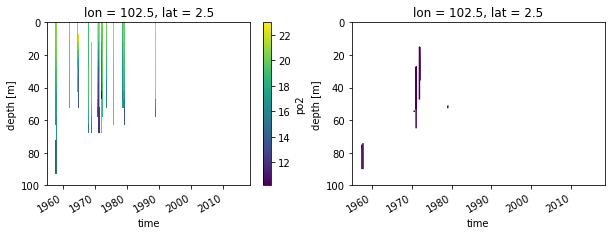

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
po2.sel(lat=2.5, lon=102.5).plot(x='time',yincrease=False, ax=axes[0])
axes[0].set_ylim(100,0)
cont=po2.sel(lat=2.5, lon=102.5).plot.contour(x='time',levels=[15],yincrease=False, ax=axes[1])
axes[1].set_ylim(100,0)

<xarray.DataArray (time: 41)>
array([35.65936373, 35.        , 30.        , 25.        , 20.        ,
       15.13178429, 20.        , 25.        , 30.        , 35.        ,
       40.        , 45.        , 47.37413128, 54.00277894, 55.        ,
       53.39353372, 50.        , 45.        , 40.        , 35.        ,
       30.        , 27.22634131, 30.        , 35.        , 40.        ,
       45.        , 50.        , 55.        , 60.        , 65.        ,
       50.99148672, 52.67350529, 74.08195077, 75.        , 80.        ,
       85.        , 90.        , 75.        , 80.        , 85.        ,
       90.        ])
Coordinates:
  * time     (time) float64 7.199e+05 7.199e+05 ... 7.146e+05 7.146e+05


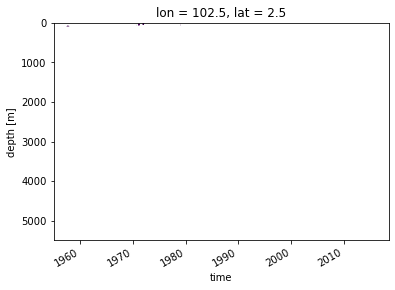

In [178]:
#https://gist.github.com/aidanheerdegen/11451b280d7e07a8f4c078820908ab4a
cont = None
cont = po2.sel(lat=2.5, lon=102.5).plot.contour(x='time',levels=[15],yincrease=False)
val = {}
for path in cont.collections[0].get_paths():
    for (x,y),s in path.iter_segments():
        val[x] = y
        #print(x,y)
        #print(val)
tmp = xr.DataArray(list(val.values()),dims=['time'],coords={'time':list(val.keys())})
print(tmp)
#isotherm[i,:] = tmp.interp(i=ds.i)